## Libraries

In [1]:
import sklearn
print(f"scikit-learn version: {sklearn.__version__}")

scikit-learn version: 1.4.2


The relevant libraries are imported. These include the numerical computation and plotting libraries.

Warnings that are occasionally generated when codes are ran are suppressed using the _"**ignore**"_ argument

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor,plot_tree
import os

# Warnings hidden
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

%config InlineBackend.figure_format='svg' # To create high resolution images

## Dataset

Data preprocessing enables us to ensure the data completeness and duplication and have a glimpse of the summary of the data statistics.

In [3]:
df= pd.read_excel("CO2_Solubility_IPTC.xlsx").drop(['References', 'Title'], axis=1)
df.dropna(inplace=True)

df=df[df['Solubility (mol/kg)'] != 0]

df

,Pressure (MPa),Temperature (K),Salinity (mol/kg),Salt type,Solubility (mol/kg)
0,0.101325,298.00,0.0,Distilled,0.033000
1,2.067030,298.00,0.0,Distilled,0.605000
2,4.134060,298.00,0.0,Distilled,1.049000
3,6.201090,298.00,0.0,Distilled,1.349000
4,8.268120,298.00,0.0,Distilled,1.395000
...,...,...,...,...,...
924,15.600000,374.68,5.0,Mgcl2,0.211916
925,20.580000,375.02,5.0,Mgcl2,0.228716
926,4.700000,424.39,5.0,Mgcl2,0.072316
927,10.340000,424.33,5.0,Mgcl2,0.128072


In [7]:
df.describe()

,Pressure (MPa),Temperature (K),Salinity (mol/kg),Solubility (mol/kg)
count,911.000000,911.000000,911.000000,911.000000
mean,13.471194,353.556235,1.535594,0.739964
std,10.250199,46.357452,2.005450,0.416120
min,0.100000,273.150000,0.000000,0.006000
25%,6.010000,323.150000,0.017094,0.415500
50%,10.335150,353.000000,0.170940,0.731000
75%,19.302412,373.150000,3.000000,1.056500
max,40.000000,473.650000,6.000000,1.774000


In [8]:
# Remove duplicate rows based on all columns and keep only the first occurrence
df.drop_duplicates(inplace=True)

# Identify duplicate rows based on all columns
duplicate_rows = df[df.duplicated()]

# Print or store the duplicate rows
if not duplicate_rows.empty:
    print("Duplicate Rows:")
    print(duplicate_rows)
    # Save duplicate rows to a new CSV file
    duplicate_rows.to_csv('duplicate_rows.csv', index=False)
else:
    print("No duplicate rows found.")

No duplicate rows found.


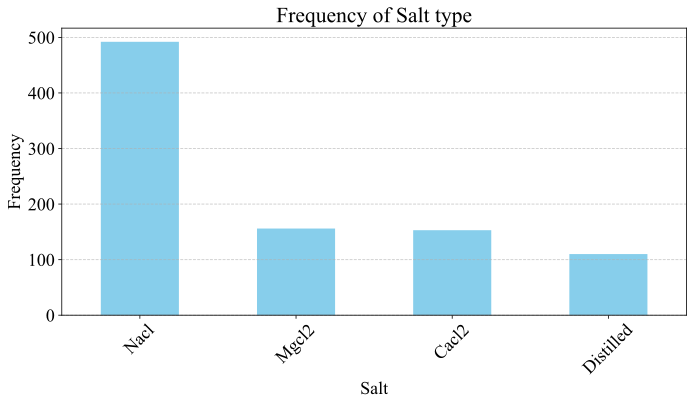

In [9]:
# Frequency of salt type

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 18

bar_data = df['Salt type'].value_counts()


plt.figure(figsize=(10, 6))

bar_data.plot(kind='bar', color='skyblue')

plt.title('Frequency of Salt type')
plt.xlabel('Salt')
plt.ylabel('Frequency')

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout() 
plt.show()

In [10]:
# Dependent and independent variables
X= df. drop(['Solubility (mol/kg)'],axis=1)
y=df['Solubility (mol/kg)'].astype(float)

In [11]:
# Encoding categorical variables (Salt type)
# One-hot encoding is used other than label encoding because the categories are not ordinal 
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
X_encoded = pd.get_dummies(X, columns=categorical_columns)

In [12]:
# Data split into training and test sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_encoded,y, random_state=5,train_size=.7)

In [13]:
# Normalization of input instances
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

# 1. **Decision Tree**

#### Hyperparameter tuning

The GridSearchCV approach is utilized for hyperparameter optimization to improve model performance. The k-fold cross-validation technique is used in this case.

In [14]:
import time
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform, randint

# Parameter grid
param_grid = {
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': np.arange(3,31),
    'min_samples_split': np.arange(1,11),
    'min_samples_leaf': np.arange(1, 11)
    }

# Start time
start_time = time.time()

dt_model = DecisionTreeRegressor()

grid_search = GridSearchCV(dt_model, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

# Best parameters and corresponding score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# Stop the timer
end_time = time.time()

# Elapsed time
elapsed_time = end_time - start_time

print(f"Hyperparameter tuning time: {elapsed_time} seconds")

Fitting 5 folds for each of 8400 candidates, totalling 42000 fits
Best Parameters:  {'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score:  0.899279455241718
Hyperparameter tuning time: 19.6155743598938 seconds


#### Model training

The optimal hyperparameter values are used in training the model.

In [15]:
features = grid_search.best_params_['max_features']
max_depth = grid_search.best_params_['max_depth']
min_samples_split = grid_search.best_params_['min_samples_split']
min_samples_leaf = grid_search.best_params_['min_samples_leaf']

In [16]:
dt = DecisionTreeRegressor(max_features = features,
                           max_depth = max_depth,
                           min_samples_split = min_samples_split,
                           min_samples_leaf = min_samples_leaf)

dt.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=14, max_features='sqrt')

In [17]:
import joblib

# Model save
joblib.dump(dt, 'DT.joblib')

# Load model for predictions
loaded_dt_model = joblib.load('DT.joblib')

#### Evaluating model performance

Here, various statistical metrics such as mean absolute error, root mean square, and coefficient of determination are used to assess the performance of the constructed model.

In [18]:
# Dependent and independent variables
X_all = scaler.fit_transform(np.array(X_encoded))
y_all = np.array(y)

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Coefficient of determination (R2)
dt_trainscore = loaded_dt_model.score(X_train, y_train)
dt_testscore = loaded_dt_model.score(X_test, y_test)
dt_allscore = loaded_dt_model.score(X_all, y_all)

# Mean absolute error (MAE)
dt_mean_abs_train=mean_absolute_error(y_train,loaded_dt_model.predict(X_train))
dt_mean_abs_test=mean_absolute_error(y_test,loaded_dt_model.predict(X_test))
dt_mean_abs_all=mean_absolute_error(y_all,loaded_dt_model.predict(X_all))


# Root mean square error (RMSE)
dt_root_mean_squared_train=(mean_squared_error(y_train,loaded_dt_model.predict(X_train)))**0.5
dt_root_mean_squared_test=(mean_squared_error(y_test,loaded_dt_model.predict(X_test)))**0.5
dt_root_mean_squared_all=(mean_squared_error(y_all,loaded_dt_model.predict(X_all)))**0.5


# Average absolute percentage relative error (AAPRE) 
dt_aapre_train = np.mean(np.abs((y_train- loaded_dt_model.predict(X_train)) / y_train))*100
dt_aapre_test = np.mean(np.abs((y_test- loaded_dt_model.predict(X_test)) / y_test))*100
dt_aapre_all = np.mean(np.abs((y_all- loaded_dt_model.predict(X_all)) / y_all))*100

In [20]:
dt_summary = {
    'R$^{2}$': [dt_trainscore, dt_testscore, dt_allscore],
    'MAE': [dt_mean_abs_train, dt_mean_abs_test, dt_mean_abs_all],
    'RMSE': [dt_root_mean_squared_train, dt_root_mean_squared_test, dt_root_mean_squared_all],
    'AAPRE' : [dt_aapre_train, dt_aapre_test, dt_aapre_all]
}

In [21]:
dt_summary = pd.DataFrame(dt_summary).T

In [22]:
dt_summary = dt_summary.rename(columns = {0: 'Train', 1: 'Test', 2: 'All'})

In [23]:
dt_summary

,Train,Test,All
R$^{2}$,0.999315,0.898408,0.971200
MAE,0.002728,0.078458,0.025505
RMSE,0.011051,0.127586,0.070579
AAPRE,5.839939,24.656075,11.499238


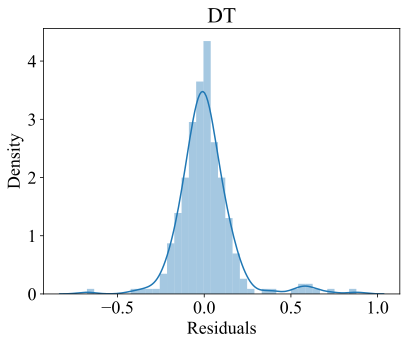

In [20]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 18

prediction_dt = loaded_dt_model.predict(X_test)

# Create a distribution plot of the residuals
sns.distplot(y_test - prediction_dt)

# Add labels and title
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('DT')

# Save the plot as a file
plt.savefig('DT_residuals_distribution.png', format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [79]:
from scipy.stats import skew

skewness_residuals = pd.DataFrame(prediction_dt).skew()

skewness_residuals

0    0.061298
dtype: float64

#### Model predictions for train, test, and entire dataset

##### Train data

In [21]:
# Excel sheet for train dataset predictions

# Dataframe for train dataset
df1=pd.DataFrame(y_train)

# Predictions for out-of-sample data
df2=pd.DataFrame(loaded_dt_model.predict(X_train), columns=['Train'])

df2.index=df1.index   # Ensuring the corresponding indices in both columns are taken

# Concatenating the observed solubility and average predicted solubility values for the train dataset
trainpred=pd.concat([df1,df2],axis=1)

# Excel sheet for test set predictions
# trainpred.to_excel("DT_Train.xlsx", index = False)

##### Test data

In [22]:
# Excel sheet for out-of-sample dataset predictions

# Dataframe for out-of-sample data (test set)
df1=pd.DataFrame(y_test)

# Predictions for out-of-sample data
df2=pd.DataFrame(loaded_dt_model.predict(X_test), columns=['Test'])

df2.index=df1.index   # Ensuring the corresponding indices in both columns are taken

# Concatenating the observed solubility and average predicted solubility values for the test dataset
testpred=pd.concat([df1,df2],axis=1)

# Excel sheet for test set predictions
testpred.to_excel("DT_Test.xlsx", index = False)

##### All data

In [23]:
# Excel sheet for entire dataset predictions

# Dataframe for out-of-sample data (test set) with renamed column
df1=pd.DataFrame(y_all)
df1 = df1.rename(columns={0: 'Solubility (mol/kg)'})

# Predictions for out-of-sample data
df2=pd.DataFrame(loaded_dt_model.predict(X_all), columns=['All'])

df2.index=df1.index   # Ensuring the corresponding indices in both columns are taken

# Concatenating the observed solubility and average predicted solubility values for the entire dataset
allpred=pd.concat([df1,df2],axis=1)

# Excel sheet for test set predictions
# allpred.to_excel("DT_All.xlsx", index = False)

#### Permutation importance

Contrary to the correlations matrices, permutation importance considers the non-monotonic effect of the features on the output.

Pressure (MPa): 0.9069931122759357
Salinity (mol/kg): 0.6064040153721739
Temperature (K): 0.45309577659801925
Salt type_Nacl: 0.07211794381463339
Salt type_Distilled: 0.0674453315567449
Salt type_Mgcl2: 0.027763524704333332
Salt type_Cacl2: 0.012862154861451624


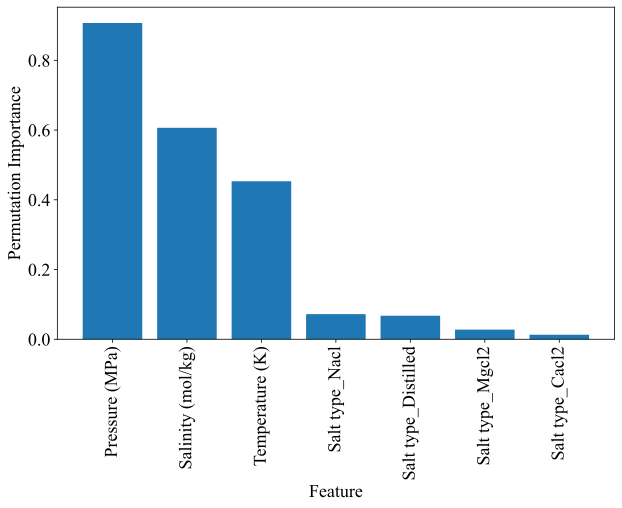

In [24]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt


# Permutation importance
result = permutation_importance(dt, X_test, y_test, n_repeats=30, random_state=0, n_jobs=-1)

# Feature importance and scores
feature_importance = result.importances_mean
feature_names = X_encoded.columns

# Sorted feature importance
sorted_idx = np.argsort(feature_importance)[::-1]

for i in sorted_idx:
    print(f'{feature_names[i]}: {feature_importance[i]}')

plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.xticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.show()

#### Akaike Information Criterion (AIC)

The AIC provides insights into the goodness of fit of the model and the model complexity. The AIC is given by the mathematical relation:
           
**$$AIC = 2[P_{N} - ln(likelihood)]$$**

where P$_{N}$ is the number of parameters in the model

In [25]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

y_pred = loaded_dt_model.predict(X_test)

dt_aic = OLS(y_test, add_constant(y_pred)).fit()
print('AIC:', dt_aic.aic)

AIC: -292.458082562561


#### Shapley Additive Explanations (SHAP)

The **Shapley Additive Explanations (SHAP)** provides insights into the impact of each of the instance on the final model prediction.

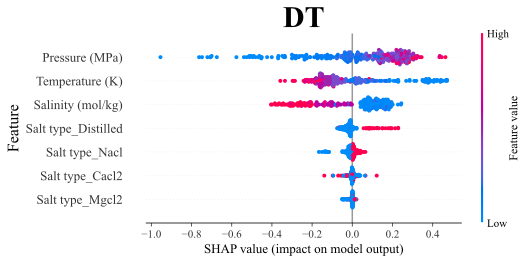

In [26]:
import shap
shap.initjs()

feature_names = X_encoded.columns

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 28

# SHAP explainer
explainer = shap.Explainer(dt)

shap_values = explainer.shap_values(X_test)
sample_index = 0

plt.figure(figsize=(15, 10))

plt.title("DT", fontsize=30, fontweight='bold')

shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)

plt.ylabel("Feature", fontsize=16)

plt.savefig('DT_SHAP_plot.png',
            format='png', 
            dpi=300, 
            bbox_inches='tight')

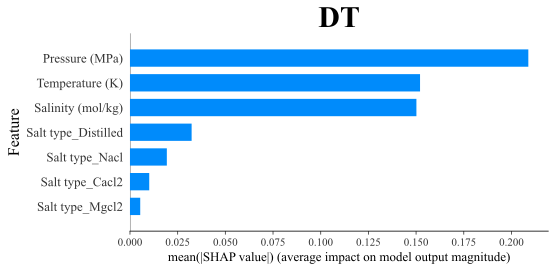

In [27]:
# Mean SHAP value
import shap
shap.initjs()

feature_names = X_encoded.columns

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 24

# SHAP explainer
explainer = shap.Explainer(dt)

shap_values = explainer.shap_values(X_test)
sample_index = 0

plt.figure(figsize=(15, 10))

plt.title("DT", fontsize=30, fontweight='bold')

shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar", auto_size_plot=None, show=False)

plt.ylabel("Feature", fontsize=16)

plt.savefig('DT_Mean_SHAP_plot.png', 
            format='png', 
            dpi=900, 
            bbox_inches='tight')

# **2. Mulitple Linear Regression** 

In [28]:
from sklearn.linear_model import LinearRegression

mlr=LinearRegression()

In [29]:
mlr.fit(X_train,y_train)

LinearRegression()

In [30]:
import joblib

# Model save
joblib.dump(mlr, 'MLR.joblib')

# Load model for predictions
loaded_mlr_model = joblib.load('MLR.joblib')

#### Evaluating model performance

In [31]:
# Coefficient of determination (R2)
mlr_trainscore = loaded_mlr_model.score(X_train, y_train)
mlr_testscore = loaded_mlr_model.score(X_test, y_test)
mlr_allscore = loaded_mlr_model.score(X_all, y_all)

# Mean absolute error (MAE)
mlr_mean_abs_train=mean_absolute_error(y_train,loaded_mlr_model.predict(X_train))
mlr_mean_abs_test=mean_absolute_error(y_test,loaded_mlr_model.predict(X_test))
mlr_mean_abs_all=mean_absolute_error(y_all,loaded_mlr_model.predict(X_all))

# Root mean square error (RMSE)
mlr_root_mean_squared_train=(mean_squared_error(y_train,loaded_mlr_model.predict(X_train)))**0.5
mlr_root_mean_squared_test=(mean_squared_error(y_test,loaded_mlr_model.predict(X_test)))**0.5
mlr_root_mean_squared_all=(mean_squared_error(y_all,loaded_mlr_model.predict(X_all)))**0.5

# Mean absolute percentage error (MAPE) 
mlr_mape_train = np.mean(np.abs((y_train- loaded_mlr_model.predict(X_train)) / y_train))*100
mlr_mape_test = np.mean(np.abs((y_test- loaded_mlr_model.predict(X_test)) / y_test))*100
mlr_mape_all = np.mean(np.abs((y_all- loaded_mlr_model.predict(X_all)) / y_all))*100

In [32]:
mlr_summary = {
    'R$^{2}$': [mlr_trainscore, mlr_testscore, mlr_allscore],
    'MAE': [mlr_mean_abs_train, mlr_mean_abs_test, mlr_mean_abs_all],
    'RMSE': [mlr_root_mean_squared_train, mlr_root_mean_squared_test, mlr_root_mean_squared_all],
    'MAPE' : [mlr_mape_train, mlr_mape_test, mlr_mape_all]
}

In [33]:
mlr_summary = pd.DataFrame(mlr_summary).T

In [34]:
mlr_summary = mlr_summary.rename(columns = {0: 'Train', 1: 'Test', 2: 'All'})

In [35]:
mlr_summary

,Train,Test,All
R$^{2}$,0.656890,0.629864,0.649421
MAE,0.189220,0.190228,0.189523
RMSE,0.247407,0.243532,0.246248
MAPE,230.163793,146.894271,205.118953


In [37]:
# # Distribution of residuals

# prediction_mlr = loaded_mlr_model.predict(X_test)

# sns.distplot(y_test - prediction_mlr, edgecolor='black')  # Add 'edgecolor' for black margins

# # Add labels and title
# plt.xlabel('Residuals')
# plt.ylabel('Density')
# plt.title('MLR')

# # Configure margins
# plt.subplots_adjust(left=0.15, bottom=0.15)  # Adjust margins around the plot

# # Save the plot 
# plt.savefig('MLR_residuals_distribution.png', format='png', dpi=300, bbox_inches='tight')

# # Show the plot
# plt.show()


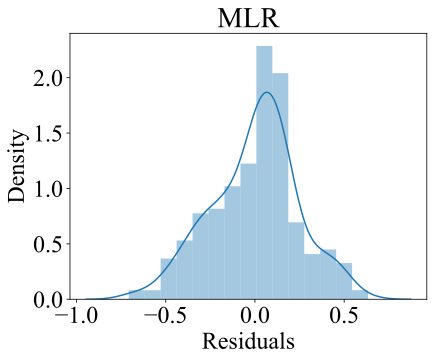

In [38]:
# Distribution of residuals

prediction_mlr = loaded_mlr_model.predict(X_test)

# Create a distribution plot of the residuals
sns.distplot(y_test - prediction_mlr)

# Add labels and title
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('MLR')

# Save the plot as a file
plt.savefig('MLR_residuals_distribution.png', format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [80]:
from scipy.stats import skew

skewness_residuals = pd.DataFrame(prediction_mlr).skew()

skewness_residuals

0   -0.193451
dtype: float64

#### Model predictions for train, test, and entire dataset

##### Train data

In [39]:
# Excel sheet for train dataset predictions

# Dataframe for train dataset
df1=pd.DataFrame(y_train)

# Predictions for out-of-sample data
df2=pd.DataFrame(loaded_mlr_model.predict(X_train), columns=['Train'])

df2.index=df1.index   # Ensuring the corresponding indices in both columns are taken

# Concatenating the observed solubility and average predicted solubility values for the train dataset
trainpred=pd.concat([df1,df2],axis=1)

# Excel sheet for test set predictions
# trainpred.to_excel("MLR_Train.xlsx", index = False)

##### Test data

In [40]:
# Excel sheet for out-of-sample dataset predictions

# Dataframe for out-of-sample data (test set)
df1=pd.DataFrame(y_test)

# Predictions for out-of-sample data
df2=pd.DataFrame(loaded_mlr_model.predict(X_test), columns=['Test'])

df2.index=df1.index   # Ensuring the corresponding indices in both columns are taken

# Concatenating the observed solubility and average predicted solubility values for the test dataset
testpred=pd.concat([df1,df2],axis=1)

# Excel sheet for test set predictions
testpred.to_excel("MLR_Test.xlsx", index = False)

##### All data

In [41]:
# Excel sheet for entire dataset predictions

# Dataframe for out-of-sample data (test set) with renamed column
df1=pd.DataFrame(y_all)
df1 = df1.rename(columns={0: 'Solubility (mol/kg)'})

# Predictions for out-of-sample data
df2=pd.DataFrame(loaded_mlr_model.predict(X_all), columns=['All'])

df2.index=df1.index   # Ensuring the corresponding indices in both columns are taken

# Concatenating the observed solubility and average predicted solubility values for the entire dataset
allpred=pd.concat([df1,df2],axis=1)

# Excel sheet for test set predictions
# allpred.to_excel("MLR_All.xlsx", index = False)

#### Permutation importance

Contrary to the correlations matrices, permutation importance considers the non-monotonic effect of the features on the output.

Pressure (MPa): 0.7299742300090334
Salinity (mol/kg): 0.725489490581524
Temperature (K): 0.22251064528548833
Salt type_Nacl: 0.006486071798580044
Salt type_Mgcl2: 0.00036099337372115975
Salt type_Cacl2: 4.506396649706091e-06
Salt type_Distilled: -0.0004599081287925522


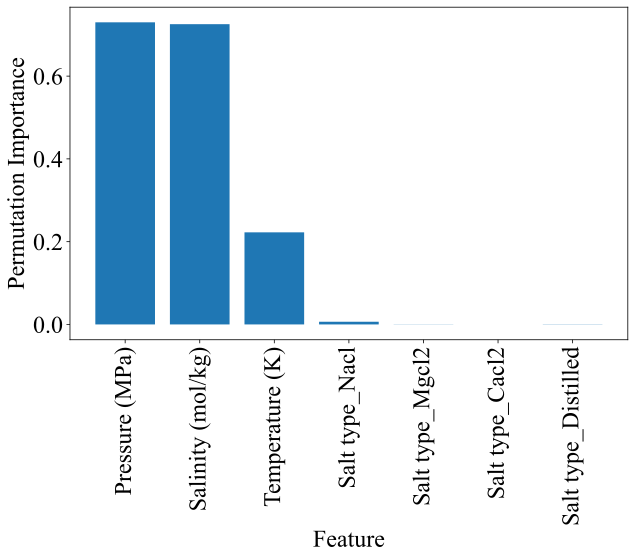

In [42]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt


# Permutation importance
result = permutation_importance(mlr, X_test, y_test, n_repeats=30, random_state=0, n_jobs=-1)

# Feature importance and scores
feature_importance = result.importances_mean
feature_names = X_encoded.columns

# Sorted feature importance
sorted_idx = np.argsort(feature_importance)[::-1]

for i in sorted_idx:
    print(f'{feature_names[i]}: {feature_importance[i]}')

plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.xticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.show()

#### AIC

In [43]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

y_pred = loaded_dt_model.predict(X_test)

dt_aic = OLS(y_test, add_constant(y_pred)).fit()
print('AIC:', dt_aic.aic)

AIC: -292.458082562561


#### SHAP

In [44]:
# import shap
# shap.initjs()

# feature_names = X_encoded.columns

# plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams["font.size"] = 28

# # SHAP explainer
# explainer = shap.Explainer(mlr)

# shap_values = explainer.shap_values(X_test)
# sample_index = 0

# plt.figure(figsize=(15, 10))

# plt.title("MLR", fontsize=30, fontweight='bold')

# shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)

# plt.ylabel("Feature", fontsize=16)

# plt.savefig('MLR_SHAP_plot.png',
#             format='png', 
#             dpi=300, 
#             bbox_inches='tight')

In [45]:
# # Mean SHAP value
# import shap
# shap.initjs()

# feature_names = X_encoded.columns

# plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams["font.size"] = 24

# # SHAP explainer
# explainer = shap.Explainer(mlr)

# shap_values = explainer.shap_values(X_test)
# sample_index = 0

# plt.figure(figsize=(15, 10))

# plt.title("DT", fontsize=30, fontweight='bold')

# shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar", auto_size_plot=None, show=False)

# plt.ylabel("Feature", fontsize=16)

# plt.savefig('DT_Mean_SHAP_plot.png', 
#             format='png', 
#             dpi=900, 
#             bbox_inches='tight')

# **3. Random Forest**

In [46]:
from sklearn.ensemble import RandomForestRegressor

In [47]:
import time
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.ensemble import RandomForestRegressor

# Parameter grid
param_grid = {
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': np.arange(5, 21),
    'n_estimators': np.arange(100, 150),
    'min_samples_split': np.arange(2, 6),
    'min_samples_leaf': np.arange(1, 6),
    'bootstrap': [True, False]
}

# Start time
start_time = time.time()

rf_model = RandomForestRegressor()

grid_search = GridSearchCV(rf_model, param_grid=param_grid, cv=2, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

# Best parameters and corresponding score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# Stop the timer
end_time = time.time()

# Elapsed time
elapsed_time = end_time - start_time

print(f"Hyperparameter tuning time: {elapsed_time} seconds")

Fitting 2 folds for each of 96000 candidates, totalling 192000 fits
Best Parameters:  {'bootstrap': False, 'max_depth': 19, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score:  0.9448079288892579
Hyperparameter tuning time: 11678.09936094284 seconds


In [48]:
features = grid_search.best_params_['max_features']
max_depth = grid_search.best_params_['max_depth']
n_estimators = grid_search.best_params_['n_estimators']
min_samples_split = grid_search.best_params_['min_samples_split']
min_samples_leaf = grid_search.best_params_['min_samples_leaf']
bootstrap = grid_search.best_params_['bootstrap']

In [49]:
rf = RandomForestRegressor(
    max_depth=max_depth,
    n_estimators=n_estimators,
    max_features = features,
    min_samples_split = min_samples_split,
    min_samples_leaf = min_samples_leaf,
    bootstrap = bootstrap    
)

rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=False, max_depth=19, max_features='sqrt')

In [50]:
import joblib

# Model save
joblib.dump(rf, 'RF.joblib')

# Load model for predictions
loaded_rf_model = joblib.load('RF.joblib')

In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Coefficient of determination (R2)
rf_trainscore = loaded_rf_model.score(X_train, y_train)
rf_testscore = loaded_rf_model.score(X_test, y_test)
rf_allscore = loaded_rf_model.score(X_all, y_all)

# Mean absolute error (MAE)
rf_mean_abs_train=mean_absolute_error(y_train,loaded_rf_model.predict(X_train))
rf_mean_abs_test=mean_absolute_error(y_test,loaded_rf_model.predict(X_test))
rf_mean_abs_all=mean_absolute_error(y_all,loaded_rf_model.predict(X_all))


# Root mean square error (RMSE)
rf_root_mean_squared_train=(mean_squared_error(y_train,loaded_rf_model.predict(X_train)))**0.5
rf_root_mean_squared_test=(mean_squared_error(y_test,loaded_rf_model.predict(X_test)))**0.5
rf_root_mean_squared_all=(mean_squared_error(y_all,loaded_rf_model.predict(X_all)))**0.5


# Average absolute percentage relative error (AAPRE) 
rf_aapre_train = np.mean(np.abs((y_train- loaded_rf_model.predict(X_train)) / y_train))*100
rf_aapre_test = np.mean(np.abs((y_test- loaded_rf_model.predict(X_test)) / y_test))*100
rf_aapre_all = np.mean(np.abs((y_all- loaded_rf_model.predict(X_all)) / y_all))*100

In [52]:
rf_summary = {
    'R$^{2}$': [rf_trainscore, rf_testscore, rf_allscore],
    'MAE': [rf_mean_abs_train, rf_mean_abs_test, rf_mean_abs_all],
    'RMSE': [rf_root_mean_squared_train, rf_root_mean_squared_test, rf_root_mean_squared_all],
    'AAPRE' : [rf_aapre_train, rf_aapre_test, rf_aapre_all]
}

In [53]:
rf_summary = pd.DataFrame(rf_summary).T

In [54]:
rf_summary = rf_summary.rename(columns = {0: 'Train', 1: 'Test', 2: 'All'})

In [55]:
rf_summary

,Train,Test,All
R$^{2}$,1.000000e+00,0.955045,0.987474
MAE,9.246468e-07,0.050523,0.015196
RMSE,1.233198e-05,0.084872,0.046546
AAPRE,1.069776e-04,23.452244,7.053768


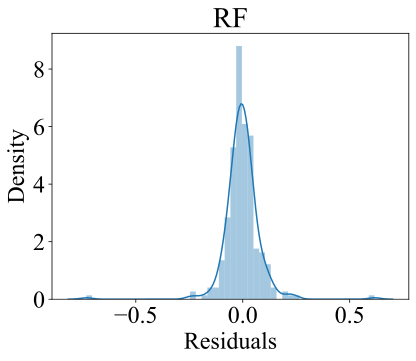

In [73]:
prediction_rf = loaded_rf_model.predict(X_test)

# Create a distribution plot of the residuals
sns.distplot(y_test - prediction_rf)

# Add labels and title
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('RF')

# Save the plot as a file
plt.savefig('RF_residuals_distribution.png', format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [76]:
from scipy.stats import skew

skewness_residuals = pd.DataFrame(prediction_rf).skew()

skewness_residuals

0    0.162779
dtype: float64

#### Model predictions for train, test, and entire dataset

##### Train data

In [57]:
# Excel sheet for train dataset predictions

# Dataframe for train dataset
df1=pd.DataFrame(y_train)

# Predictions for out-of-sample data
df2=pd.DataFrame(loaded_rf_model.predict(X_train), columns=['Train'])

df2.index=df1.index   # Ensuring the corresponding indices in both columns are taken

# Concatenating the observed solubility and average predicted solubility values for the train dataset
trainpred=pd.concat([df1,df2],axis=1)

# Excel sheet for test set predictions
# trainpred.to_excel("RF_Train.xlsx", index = False)

##### Test data

In [58]:
# Excel sheet for out-of-sample dataset predictions

# Dataframe for out-of-sample data (test set)
df1=pd.DataFrame(y_test)

# Predictions for out-of-sample data
df2=pd.DataFrame(loaded_rf_model.predict(X_test), columns=['Test'])

df2.index=df1.index   # Ensuring the corresponding indices in both columns are taken

# Concatenating the observed solubility and average predicted solubility values for the test dataset
testpred=pd.concat([df1,df2],axis=1)

# Excel sheet for test set predictions
testpred.to_excel("RF_Test.xlsx", index = False)

##### All data

In [59]:
# Excel sheet for entire dataset predictions

# Dataframe for out-of-sample data (test set) with renamed column
df1=pd.DataFrame(y_all)
df1 = df1.rename(columns={0: 'Solubility (mol/kg)'})

# Predictions for out-of-sample data
df2=pd.DataFrame(loaded_rf_model.predict(X_all), columns=['All'])

df2.index=df1.index   # Ensuring the corresponding indices in both columns are taken

# Concatenating the observed solubility and average predicted solubility values for the entire dataset
allpred=pd.concat([df1,df2],axis=1)

# Excel sheet for test set predictions
# allpred.to_excel("RF_All.xlsx", index = False)

#### Permutation Importance

Pressure (MPa): 0.962743889664916
Salinity (mol/kg): 0.6643482777856494
Temperature (K): 0.3957362636003985
Salt type_Nacl: 0.02273472109831188
Salt type_Distilled: 0.009856507049684627
Salt type_Cacl2: 0.004591989904269544
Salt type_Mgcl2: 0.0018089439782840832


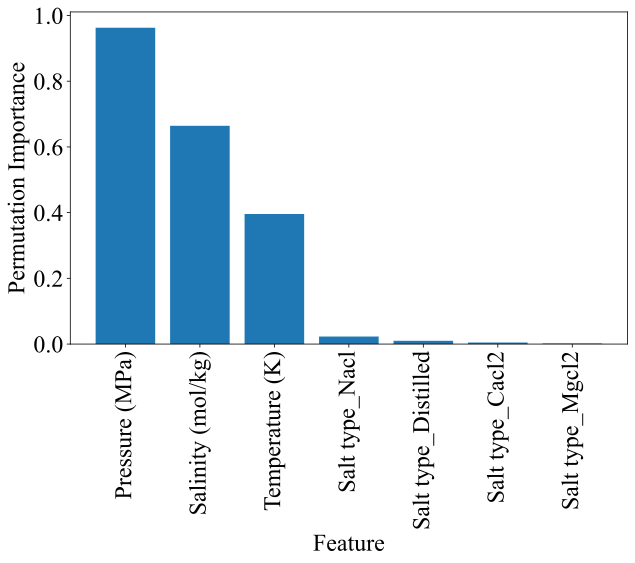

In [60]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt


# Permutation importance
result = permutation_importance(rf, X_test, y_test, n_repeats=30, random_state=0, n_jobs=-1)

# Feature importance and scores
feature_importance = result.importances_mean
feature_names = X_encoded.columns

# Sorted feature importance
sorted_idx = np.argsort(feature_importance)[::-1]

for i in sorted_idx:
    print(f'{feature_names[i]}: {feature_importance[i]}')

plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.xticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.show()

#### AIC

In [61]:
# AIC
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

y_pred = loaded_rf_model.predict(X_test)

rf_aic = OLS(y_test, add_constant(y_pred)).fit()
print('AIC:', rf_aic.aic)

AIC: -587.7595822542919


#### SHAP

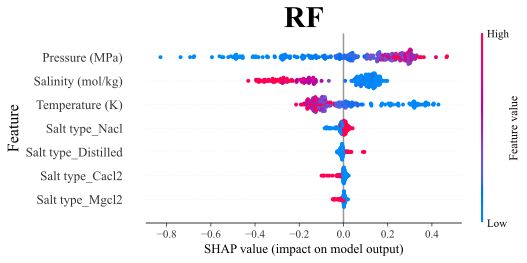

In [62]:
import shap
shap.initjs()

feature_names = X_encoded.columns

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 28

# SHAP explainer
explainer = shap.Explainer(rf)

shap_values = explainer.shap_values(X_test)
sample_index = 0

plt.figure(figsize=(15, 10))

plt.title("RF", fontsize=30, fontweight='bold')

shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)

plt.ylabel("Feature", fontsize=16)

plt.savefig('RF_SHAP_plot.png',
            format='png', 
            dpi=300, 
            bbox_inches='tight')

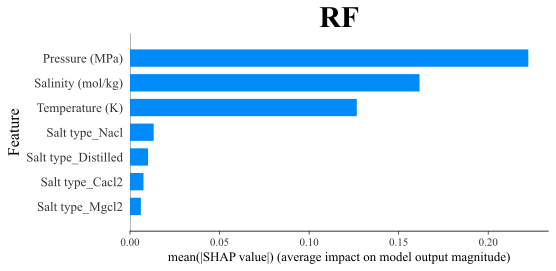

In [63]:
# Mean SHAP value
import shap
shap.initjs()

feature_names = X_encoded.columns

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 24

# SHAP explainer
explainer = shap.Explainer(rf)

shap_values = explainer.shap_values(X_test)
sample_index = 0

plt.figure(figsize=(15, 10))

plt.title("RF", fontsize=30, fontweight='bold')

shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar", auto_size_plot=None, show=False)

plt.ylabel("Feature", fontsize=16)

plt.savefig('RF_Mean_SHAP_plot.png', 
            format='png', 
            dpi=900, 
            bbox_inches='tight')